Suponemos que la barra es cilíndrica sujeta en un extremo y libre en otro.

La barra se hace oscilar (por ejemplo, dándole un golpe o un desplazamiento inicial) y se mide la variación de luz con un fotodiodo, lo que nos da una señal de voltaje vs. tiempo (la barra, al oscilar, cambia la abertura de la rendija o la posición del haz láser que llega al fotodiodo)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
import pandas as pd

## Med 8: Para el modo 1 cobre L=22.7 cm:

In [ ]:
L = 0.227  # en m
d = 0.005    # en m 
rho = 0.0088    # Probamos con cobre: como tiene impuresas la densidad deberia ser menor
beta1 = 3.5161

I = (np.pi * d**4) / 64.0
# Área de la sección
A = (np.pi * d**2) / 4.0

In [25]:
ruta = "C:/Users/FIUBA/Desktop/Labo 4/mod young/mediciones24-2/med8-24-2-cobre-22-7cm0.csv"
datos = np.loadtxt(ruta, delimiter=",", skiprows=1)

In [27]:
t = datos[:, 0]  # Vector de tiempo
V = datos[:, 1]  # Señal de voltaje

print(V)

[-0.00395983 -0.00428872 -0.00461761 ...  0.13812167  0.13812167
  0.13812167]


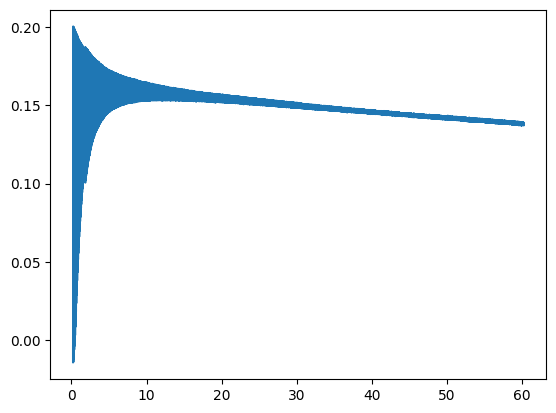

In [28]:
plt.plot(t,V)

In [29]:
file_path = "C:/Users/FIUBA/Desktop/Labo 4/mod young/mediciones24-2/med8-24-2-cobre-22-7cm0.csv"
df = pd.read_csv(file_path)

df.columns = ["t","V"]

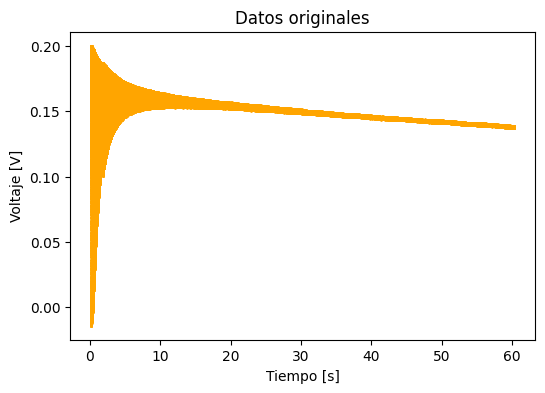

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V"], '.', markersize=2, color="orange")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje [V]")
plt.title("Datos originales")
plt.show()

# Seleccionar los últimos puntos para el ajuste lineal (por ejemplo, últimos 20% de los datos)
fraction = 0.2
n_points = int(len(df) * fraction)
df_tail = df.iloc[-n_points:]

# Ajuste lineal (mínimos cuadrados)
p = np.polyfit(df_tail["t"], df_tail["V"], 1)  # p[0] es la pendiente, p[1] es la intersección

# Crear la recta ajustada
recta_ajustada = np.polyval(p, df["t"])

# Restar la recta ajustada a los datos originales
df["V1_corregido"] = df["V"] - recta_ajustada


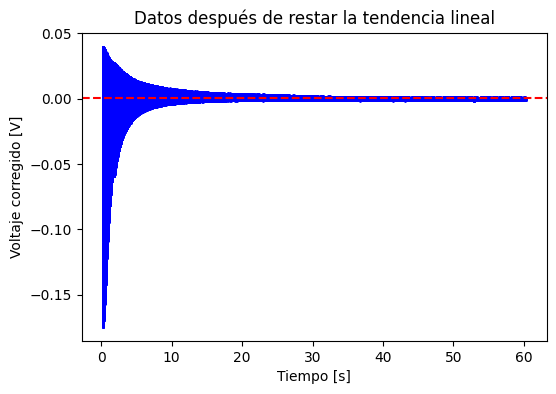

Ecuación de la recta ajustada: V(t) = -0.000372 * t + 0.160592
mean: 0.00023534211426290625


In [31]:
plt.figure(figsize=(6, 4))
plt.plot(df["t"], df["V1_corregido"], '.', markersize=2, color="blue")
plt.axhline(np.mean(df["V1_corregido"]), color='red', linestyle='--', label="Media")
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje corregido [V]")
plt.title("Datos después de restar la tendencia lineal")
plt.show()

# Mostrar la ecuación de la recta ajustada
print(f"Ecuación de la recta ajustada: V(t) = {p[0]:.6f} * t + {p[1]:.6f}")
print(f"mean: {np.mean(df['V1_corregido'])}")


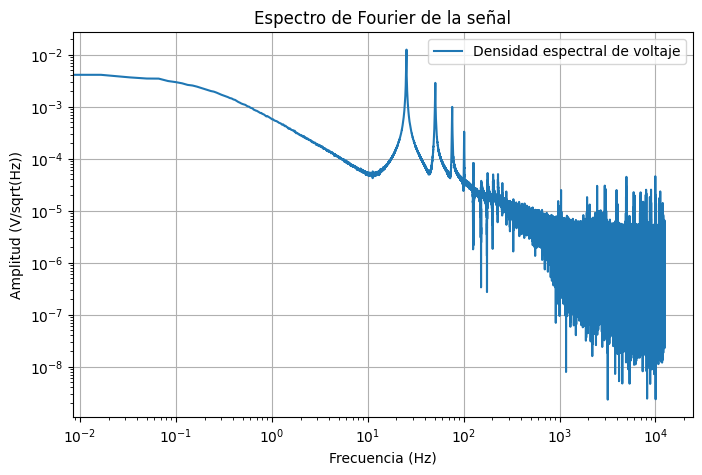

In [32]:
# Parámetros de la FFT
N = len(df["t"])  # Número de puntos
dt = np.mean(np.diff(df["t"]))  # Paso de tiempo
fs = 1 / dt  # Frecuencia de muestreo

V_fft = np.fft.fft(df["V1_corregido"])  # Transformada de Fourier
freqs = np.fft.fftfreq(N, d=dt)  # Frecuencias asociadas

V_fft = V_fft[:N//2]  # Tomamos solo la mitad positiva
freqs = freqs[:N//2]  # Frecuencias positivas
S_v = np.abs(V_fft) / np.sqrt(fs * N)  # Densidad espectral de voltaje

plt.figure(figsize=(8,5))
plt.loglog(freqs, S_v, label='Densidad espectral de voltaje')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (V/sqrt(Hz))')
plt.title('Espectro de Fourier de la señal')
plt.legend()
plt.grid()
plt.show()

C:\Users\FIUBA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


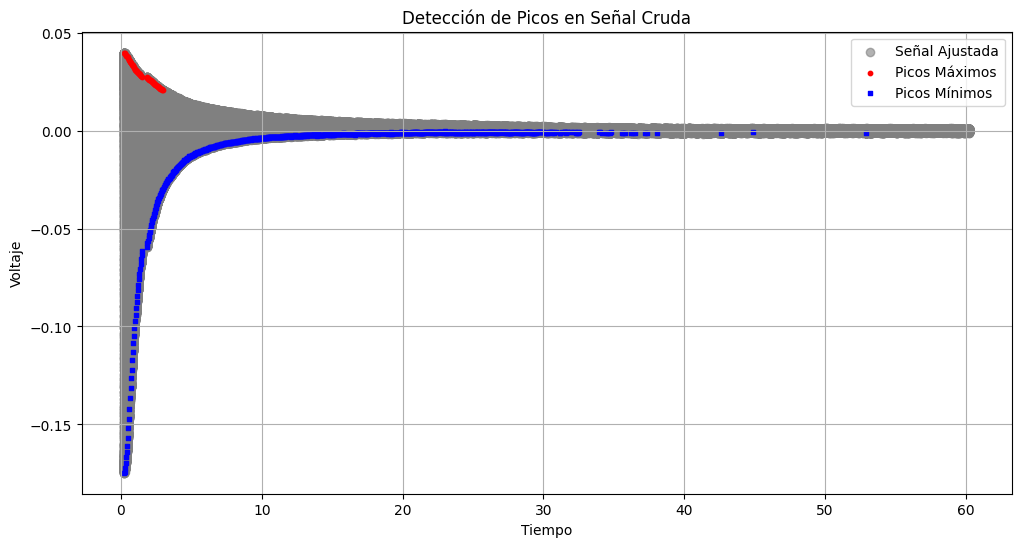

In [33]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(df["V1_corregido"][-num_puntos_finales:])
V_ajustada = df["V1_corregido"] - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=40)

#Crear listas con los valores de los picos
t_max = t[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = t[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.scatter(t, V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.scatter(t_max, V_max, label='Picos Máximos', color='red', marker='o', s=10)
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='s', s=10)

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()

Frecuencias de los picos detectados en la región 20-80 Hz:
[25.43248823 25.49910902 50.78170046]


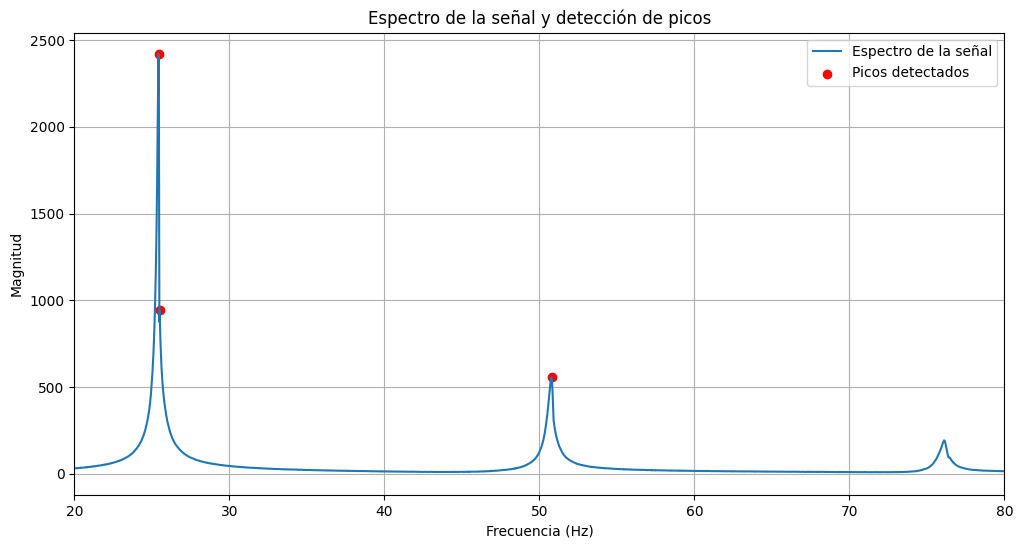

In [34]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(df["V1_corregido"][-num_puntos_finales:])
V_ajustada = df["V1_corregido"] - offset  # Restar el offset para centrar la señal

# Obtener el tiempo de muestreo
dt = np.mean(np.diff(t))  # Diferencia promedio entre puntos de tiempo
fs = 1 / dt  # Frecuencia de muestreo

# Aplicar FFT
N = len(V_ajustada)
frequencies = fftfreq(N, d=dt)  # Eje de frecuencias
spectrum = np.abs(fft(V_ajustada))  # Magnitud del espectro

# Detectar picos en el espectro
peaks, _ = find_peaks(spectrum, height=np.max(spectrum) * 0.1)

# Obtener frecuencias de los picos
peak_freqs = frequencies[peaks]

# Filtrar las frecuencias entre 20 y 80 Hz
peak_freqs_filtered = peak_freqs[(peak_freqs >= 20) & (peak_freqs <= 80)]

# Imprimir las frecuencias detectadas en la región 20-80 Hz
print("Frecuencias de los picos detectados en la región 20-80 Hz:")
print(peak_freqs_filtered)

# Graficar el espectro con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N // 2], spectrum[:N // 2], label="Espectro de la señal")  # Solo parte positiva
plt.scatter(peak_freqs_filtered, spectrum[peaks[(peak_freqs >= 20) & (peak_freqs <= 80)]], 
            color='red', label="Picos detectados", marker='o')
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.xlim(20, 80)
plt.title("Espectro de la señal y detección de picos")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
print(len(S_v))
print(len(S_v[(freqs >= 20) & (freqs <= 80)]))
print(len(frequencies))

746827
3603
1493654


Busco alfa

In [15]:
from scipy.optimize import curve_fit
from scipy.stats import chi2

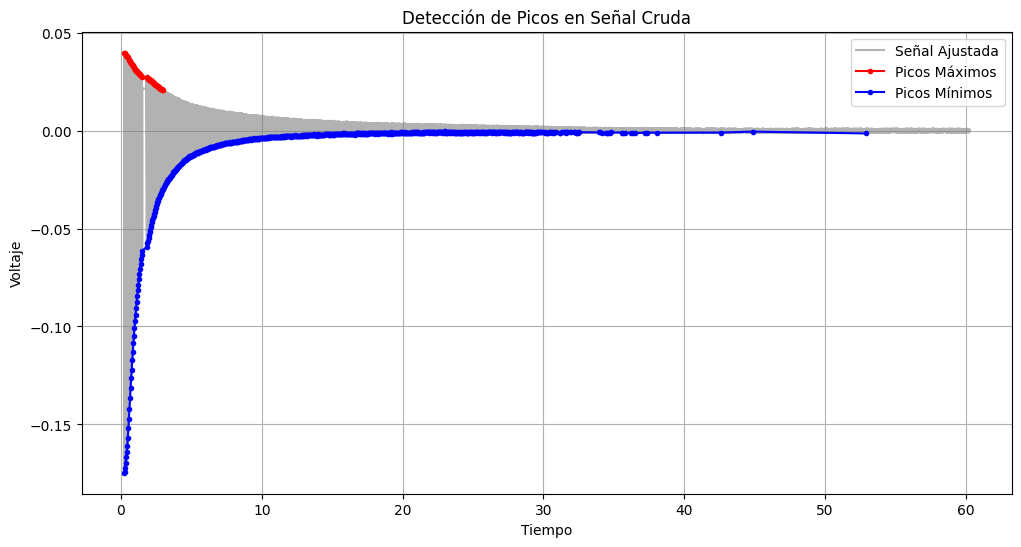

In [16]:
num_puntos_finales = 2000  # Ajusta según tu señal
offset = np.mean(df["V1_corregido"][-num_puntos_finales:])
V_ajustada = df["V1_corregido"] - offset # Restar el offset para que al final la señal quede en 0

peaks_max, _ = find_peaks(V_ajustada, height=0.001, distance=10, prominence=0.05)
peaks_min, _ = find_peaks(-V_ajustada, prominence=0.001, distance=5, width=40)

#Crear listas con los valores de los picos
t_max = t[peaks_max]
V_max = V_ajustada[peaks_max]

t_min = t[peaks_min]
V_min = V_ajustada[peaks_min]

#Graficar los datos crudos con los picos detectados
plt.figure(figsize=(12, 6))
plt.plot(t, V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.plot(t_max, V_max, label='Picos Máximos', color='red', marker='.')
plt.plot(t_min, V_min, label='Picos Mínimos', color='blue', marker='.')

# Detalles del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.title('Detección de Picos en Señal Cruda')
plt.legend()
plt.grid(True)
plt.show()


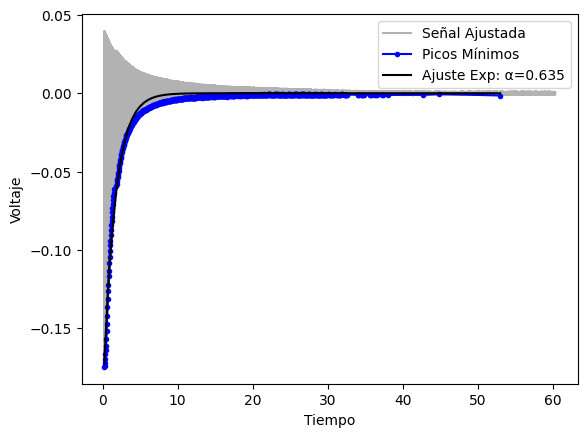

α=0.635 ± 0.005


In [17]:
def exp_decay(t, A, alpha):
    return A * np.exp(-alpha * t)

popt, pcov = curve_fit(exp_decay, t_min, V_min, p0=[max(V_min), 0.1])
A_fit, alpha_fit = popt

# Calcular el error de alpha a partir de la matriz de covarianza
alpha_error = np.sqrt(pcov[1, 1])  

t_fit = np.linspace(min(t_min), max(t_min), 100)
V_fit = exp_decay(t_fit, *popt)

plt.plot(t, V_ajustada, label="Señal Ajustada", color='gray', alpha=0.6)
plt.plot(t_min, V_min, label='Picos Mínimos', color='blue', marker='.')
plt.plot(t_fit, V_fit, label=f'Ajuste Exp: α={alpha_fit:.3f}', color='black')

plt.xlabel('Tiempo')
plt.ylabel('Voltaje')
plt.legend()
plt.show()

print(f'α={alpha_fit:.3f} ± {alpha_error:.3f}')

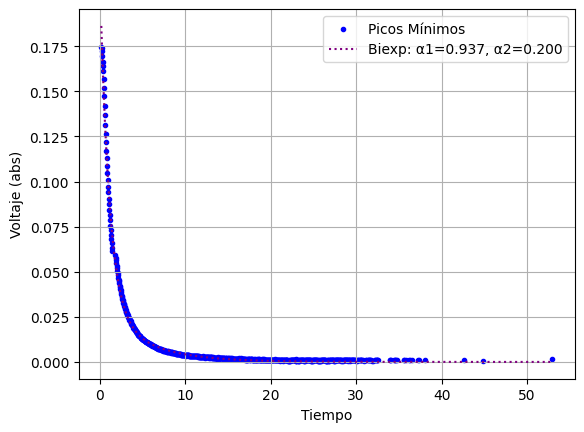

In [21]:
def biexp_decay(t, A1, alpha1, A2, alpha2):
    return A1 * np.exp(-alpha1 * t) + A2 * np.exp(-alpha2 * t)

# Convertir a arrays
t_min = np.array(t_min).flatten()
V_min = np.array(V_min).flatten()

# 📌 **CORREGIDO**: Filtrar solo `t_min`, pero NO `V_min`
mask = (t_min > 0)
t_min, V_min = t_min[mask], V_min[mask]

# 📌 **CORREGIDO**: Usar valores absolutos para ajuste
V_min = np.abs(V_min)

# Si aún no hay datos, detener el ajuste
if len(t_min) == 0 or len(V_min) == 0:
    raise ValueError("Error crítico: No hay suficientes datos para el ajuste.")

# Ajuste biexponencial
popt, pcov = curve_fit(
    biexp_decay, t_min, V_min, 
    p0=[max(V_min), 0.5, max(V_min)/2, 0.1], 
    bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
)

# Extraer parámetros
A1_fit, alpha1_fit, A2_fit, alpha2_fit = popt

# Generar curva ajustada
t_fit = np.linspace(min(t_min), max(t_min), 500)
V_fit = biexp_decay(t_fit, *popt)

# Graficar resultados
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='.')
plt.plot(t_fit, V_fit, label=f'Biexp: α1={alpha1_fit:.3f}, α2={alpha2_fit:.3f}', color='purple', linestyle='dotted')
plt.xlabel('Tiempo')
plt.ylabel('Voltaje (abs)')
plt.legend()
plt.grid()
plt.show()

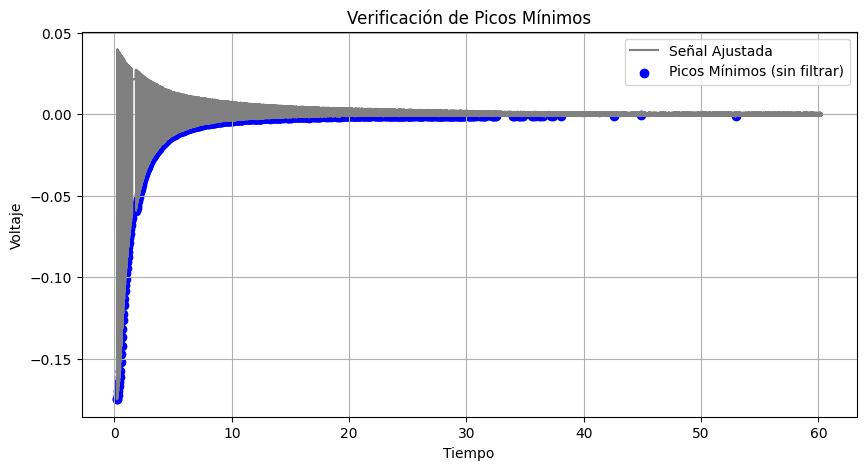

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(t, V_ajustada, label="Señal Ajustada", color="gray")
plt.scatter(t[peaks_min], V_ajustada[peaks_min], color="blue", marker="o", label="Picos Mínimos (sin filtrar)")
plt.xlabel("Tiempo")
plt.ylabel("Voltaje")
plt.title("Verificación de Picos Mínimos")
plt.legend()
plt.grid()
plt.show()


intento ajustar con una biexponencial

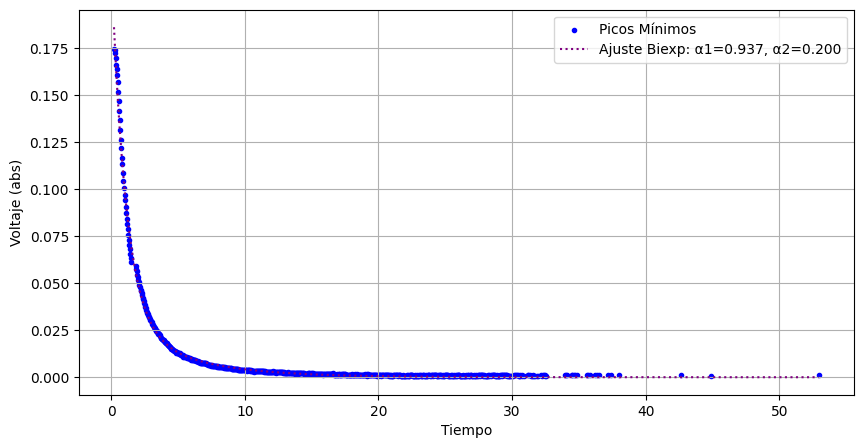

Ajuste Biexp: α1=0.937, α2=0.200


In [25]:
V_min = np.abs(V_min)  # Convertimos los valores negativos en positivos
# Ajuste con curve_fit para la biexponencial
popt, pcov = curve_fit(
    biexp_decay, t_min, V_min, 
    p0=[max(V_min), 0.5, max(V_min)/2, 0.1], 
    bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])
)

# Extraer parámetros ajustados
A1_fit, alpha1_fit, A2_fit, alpha2_fit = popt

# Generar curva ajustada
t_fit = np.linspace(min(t_min), max(t_min), 500)
V_fit = biexp_decay(t_fit, *popt)

# Graficar ajuste
plt.figure(figsize=(10, 5))
plt.scatter(t_min, V_min, label='Picos Mínimos', color='blue', marker='.')
plt.plot(t_fit, V_fit, label=f'Ajuste Biexp: α1={alpha1_fit:.3f}, α2={alpha2_fit:.3f}', color='purple', linestyle='dotted')

plt.xlabel('Tiempo')
plt.ylabel('Voltaje (abs)')
plt.legend()
plt.grid()
plt.show()
print(f'Ajuste Biexp: α1={alpha1_fit:.3f}, α2={alpha2_fit:.3f}')

In [ ]:
len(V_ajustada)

In [ ]:
len(t)

Calculamos el módulo de Young con $E = \frac{\rho (w^2+ \alpha^2)}{I k_n 4}$

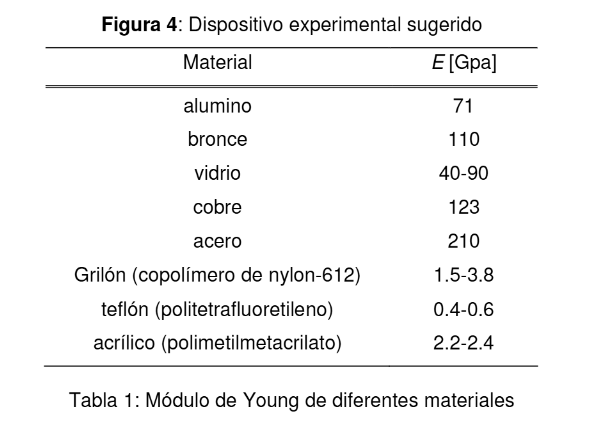

$Gpa = 10^9 Pa$

In [ ]:
L = 0.227  
n = 1  

k_n = (n * np.pi) / L
k_n

In [ ]:
def calcular_modulo_young(L, d, rho, f1, alpha):
    A = np.pi * (d / 2)**2
    I = (np.pi * d**4) / 64
    w = 2 * np.pi * f1 
    k = 13.839615214051951  # Para el modo fundamental
    n = 1  # Primer modo de vibración

    E = (A* rho * (w**2 + alpha**2)) / (I * (k)**4) 
    return E

L = 0.227
d = 0.005
rho = 8960
f1 = 25.5
alpha = 0.635

E = calcular_modulo_young(L, d, rho, f1, alpha)

print(f"El módulo de Young es: {E:.2e} Pa")

calculo errores:


In [ ]:
from uncertainties import ufloat

def calcular_modulo_young(L, d, rho, f1, alpha):
    A = np.pi * (d / 2) ** 2  
    I = (np.pi * d**4) / 64 
    w = 2 * np.pi * f1  
    k = 13.839615214051951 
    
    E = (A * rho * (w**2 + alpha**2)) / (I * k**4)  
    return E

L = ufloat(0.227, 0.001)
d = ufloat(0.005, 1e-5)
rho = ufloat(8960, 90)
f1 = ufloat(25.5, 25000 / 3603)
alpha = ufloat(0.635, 0.005)

E = calcular_modulo_young(L, d, rho, f1, alpha)

print(f"Módulo de Young: {E:.2e} Pa")

con el modelo biexponencial


In [39]:
from uncertainties import ufloat
import numpy as np

def calcular_modulo_young(L, d, rho, f1, alpha):
    A = np.pi * (d / 2) ** 2  # Área transversal
    I = (np.pi * d**4) / 64  # Momento de inercia
    w = 2 * np.pi * f1  # Frecuencia angular
    k = 13.839615214051951  # Constante para el modo fundamental
    
    E = (2*A * rho * (w**2 + alpha**2)) / (I * k**4)  
    return E

# Valores con incertidumbre
L = ufloat(0.237, 0.001)
d = ufloat(0.006, 1e-5)
rho = ufloat(8960, 90)
f1 = ufloat(25.5, 25000 / 3603)

# Parámetros biexponenciales # α1=0.937, α2=0.200
alpha1 = ufloat(0.937, 0.005)
alpha2 = ufloat(0.200, 0.005)

# Opción 1: Tomar el mayor
E1 = calcular_modulo_young(L, d, rho, f1, alpha1)

# Opción 2: Promedio geométrico
alpha_eff = (alpha1 * alpha2) ** 0.5  # Raíz cuadrada del producto
E2 = calcular_modulo_young(L, d, rho, f1, alpha_eff)

# Imprimir resultados
print(f"Módulo de Young con α1: {E1:.2e} Pa")
print(f"Módulo de Young con α_eff (prom. geom.): {E2:.2e} Pa")

Módulo de Young con α1: (5.57+/-3.03)e+09 Pa
Módulo de Young con α_eff (prom. geom.): (5.57+/-3.03)e+09 Pa


In [2]:
import numpy as np

In [50]:
alfa = 0.635
d = 0.5/100 # en metros
rho = (77/1000)*(1/(0.22))  #del cobre
I = (np.pi * (d)**4)/64
L = 0.23
k = 1.875/L
frecuencia_dominante = 25.43248823
#k = (2*np.pi)/(670*(10**(-9)))
E = ((frecuencia_dominante*2*np.pi)**2 + alfa**2) * rho /(I*(k)**4)
print(f"Módulo de Young: {E / 1e9:.2f} GPa")

Módulo de Young: 65.96 GPa


In [51]:
L_err = 0.005 
d_err = 1*10**(-5)
rho_err = 0.0033 # por impuresas me tiro chat
f_err = 25000/746827 # frec de meustreo/numero de puntos de la fft
alpha_err = 0.005 # sale de la matriz de covarianza

In [52]:
from uncertainties import ufloat

alfa_u = ufloat(alfa, alpha_err)
d_u = ufloat(d, d_err)
rho_u = ufloat(rho, rho_err)
L_u = ufloat(L, L_err)
f_u = ufloat(frecuencia_dominante, f_err)

I_u = (np.pi * d_u**4) / 64
k_u = 1.875 / L_u

E_u = ((f_u * 2 * np.pi)**2 + alfa_u**2) * rho_u / (I_u * k_u**4)

E_GPa_u = E_u / 1e9

E_GPa_u
print(f"Módulo de Young: {E_GPa_u:.2f} GPa")

Módulo de Young: 65.96+/-5.80 GPa
